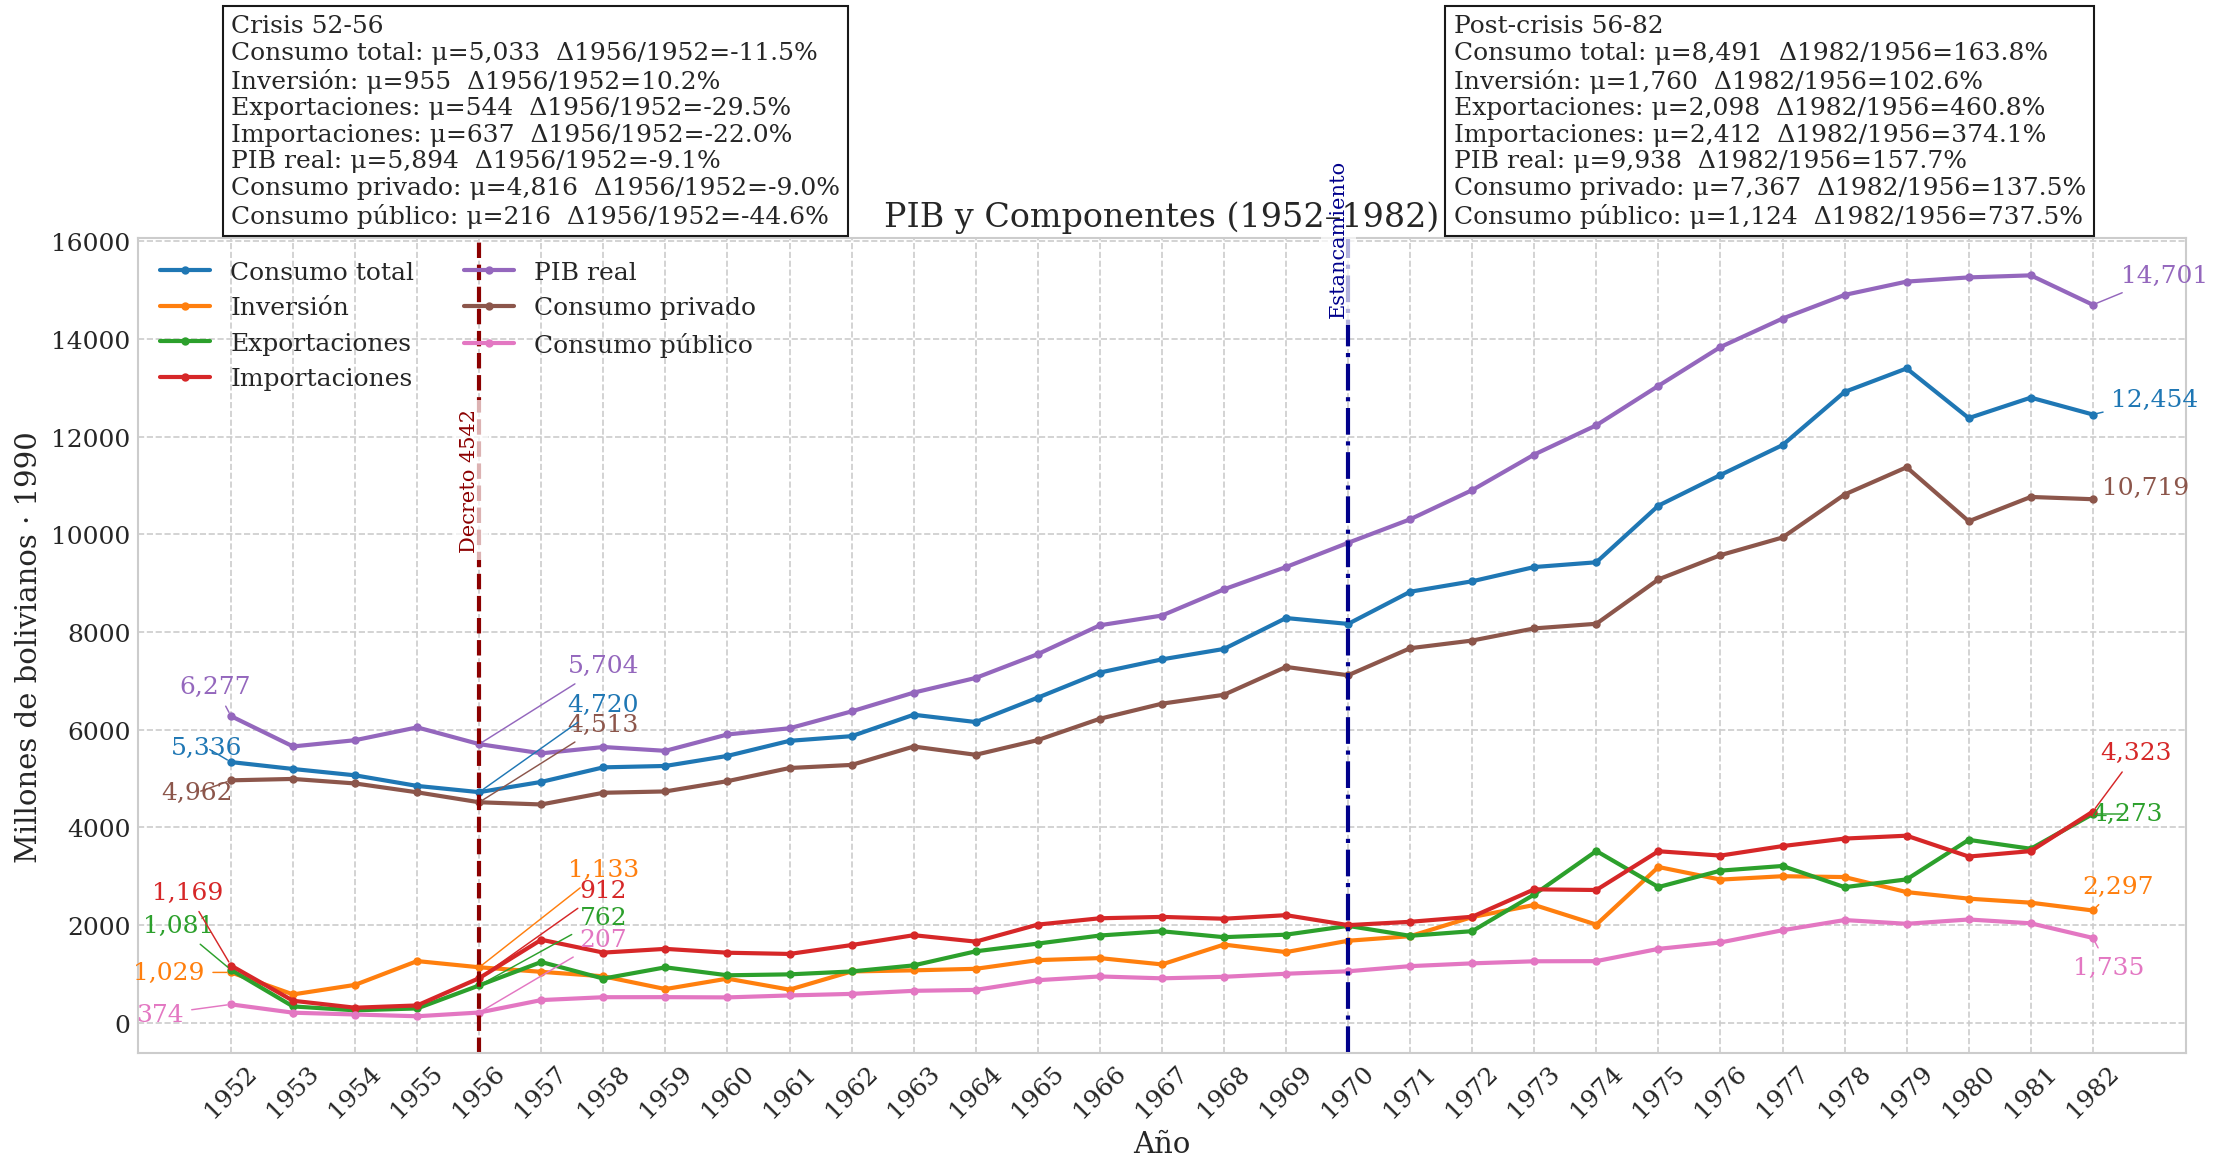

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Configuración
out = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
os.makedirs(out, exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif','font.size':12,
    'axes.titlesize':16,'axes.labelsize':14,
    'grid.linestyle':'--','lines.linewidth':2,
    'figure.dpi':150,'savefig.bbox':'tight'
})

# ── 2. Carga y filtro 1952–1982
conn = sqlite3.connect('../../../db/proyectomacro.db')
df = pd.read_sql("SELECT * FROM pib_real_gasto", conn).set_index('año')/1000
conn.close()
df = df_full = df.loc[1952:1982]
crisis = df.loc[1952:1956]
post   = df.loc[1956:1982]

componentes = [
  ("gastos_consumo",               "Consumo total"),
  ("formacion_capital",            "Inversión"),
  ("exportacion_bienes_servicios", "Exportaciones"),
  ("importacion_bienes",           "Importaciones"),
  ("pib_real_base_1990",           "PIB real"),
  ("consumo_privado",            "Consumo privado"),
  ("consumo_publico",              "Consumo público")
]

# ── 3. Estadísticas
def stats(sub, a,b):
    lines=[]
    for c,lab in componentes:
        μ=sub[c].mean()
        Δ=(df.loc[b,c]-df.loc[a,c])/df.loc[a,c]*100
        lines.append(f"{lab}: μ={μ:,.0f}  Δ{b}/{a}={Δ:.1f}%")
    return "\n".join(lines)

txt_cr = "Crisis 52-56\n"+stats(crisis,1952,1956)
txt_po = "Post-crisis 56-82\n"+stats(post,1956,1982)

# ── 4. Offsets
annotation_offsets = {
    'gastos_consumo': {
        1952: (0, 200), 1956: (0, 200), 1982: (0, 200),
    },
    'formacion_capital': {
        1952: (-1, -900), 1956: (-1, -1350), 1982: (0, -300),
    },
    'exportacion_bienes_servicios': {
        1952: (0.3, -1000), 1956: (0.3, -1000), 1982: (0, -800),
    },
    'importacion_bienes': {
        1952: (0, 900), 1956: (0, 900), 1982: (0, 900),
    },
    'pib_real_base_1990': {
        1952: (0, 250), 1956: (0, 250), 1982: (0, 250),
    },
    'consumo_privado': {
        1952: (0, -900), 1956: (0, -900), 1982: (0, -900),
    },
    'consumo_publico': {
        1952: (2, -600), 1956: (2, -300), 1982: (0.7, -300),
    }
}

# ── 3. Figura ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))
cmap = plt.get_cmap('tab10')
for i,(col,lab) in enumerate(componentes):
    ax.plot(df.index, df[col], label=lab,
            color=cmap(i), marker='o', markersize=3)

# Hitos verticales
ax.axvline(1956, color='darkred', ls='--', lw=2)
ax.text(1956, ax.get_ylim()[1]*0.60, "Decreto 4542",
        rotation=90, color='darkred', va='bottom',
        ha='right', fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax.axvline(1970, color='darkblue', ls='-.', lw=2)
ax.text(1970, ax.get_ylim()[1]*0.90, "Estancamiento",
        rotation=90, color='darkblue', va='bottom',
        ha='right', fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# ── 0. Definir custom_dy ────────────────────────────────────────────
custom_dy = {
    1952: {
        'gastos_consumo':        300,
        'formacion_capital':    0,
        'exportacion_bienes_servicios': 900,
        'importacion_bienes':   1500,
        'pib_real_base_1990':    600,
        'consumo_privado':       -250,
        'consumo_publico':       -200,
    },
    1956: {
        # misma dy para todas o individual
        'gastos_consumo':     1800,
        'formacion_capital':  2000,
        'exportacion_bienes_servicios': 1400,
        'importacion_bienes': 1800,
        'pib_real_base_1990': 1600,
        'consumo_privado':    1600,
        'consumo_publico':    1500,
    },
    1982: {
        'gastos_consumo':        300,
        'formacion_capital':    500,
        'exportacion_bienes_servicios': 0,
        'importacion_bienes':   1200,
        'pib_real_base_1990':    600,
        'consumo_privado':       250,
        'consumo_publico':       -600,
    }
}

# ── 4. Anotaciones automáticas con custom_dy ────────────────────────
years   = [1952, 1956, 1982]
x_shift = {1952: -0.7, 1956: 2, 1982: 0.7}
dy_gap  = {1952: 500, 1956: 1400, 1982: 500}
x_gap   = 0.15

for yr in years:
    vals = [(df.loc[yr,col], col, i) for i,(col,_) in enumerate(componentes)]
    vals.sort(key=lambda t: t[0])
    n = len(vals)

    for rank, (y, col, idx) in enumerate(vals):
        # Determinar dx siempre igual
        dx = x_shift[yr] if yr == 1956 else x_shift[yr] + (rank - (n-1)/2) * x_gap

        # Determinar dy: si existe custom, lo uso; si no, escalonamiento
        if yr in custom_dy and col in custom_dy[yr]:
            dy = custom_dy[yr][col]
        else:
            dy = (rank - (n-1)/2) * dy_gap[yr]

        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y),
                    xytext=(yr + dx, y + dy),
                    ha='center', va='center', fontsize=12,
                    color=cmap(idx),
                    arrowprops=dict(arrowstyle='-', color=cmap(idx), lw=0.7))



ybox = df.max().max()*1.07
ax.text(1952, ybox, txt_cr, bbox=dict(facecolor='white',alpha=0.9))
ax.text(1971.7, ybox, txt_po, bbox=dict(facecolor='white',alpha=0.9))
# ── 5. Etiquetas generales ────────────────────────────────────────
ax.set_title("PIB y Componentes (1952–1982)")
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(range(1952, 1983))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(out, "pib_52_82_full_labels.png"))
plt.show()

In [6]:
conn = sqlite3.connect('../../../db/proyectomacro.db')
df2 = pd.read_sql("SELECT * FROM pib_real_gasto", conn).set_index('año')
df2.loc[1980:1985]

,gastos_consumo,formacion_capital,exportacion_bienes_servicios,importacion_bienes,pib_real_base_1990,consumo_privado,consumo_publico
año,,,,,,,
1980,12379963.0,2539103.0,3743201.0,3401039.0,15261228.0,10267573.0,2112391.0
1981,12799164.0,2456339.0,3560467.0,3512679.0,15303291.0,10765253.0,2033911.0
1982,12453640.0,2296813.0,4272614.0,4322532.0,14700534.0,10718735.0,1734905.0
1983,11635462.0,1867427.0,3994456.0,3391024.0,14106321.0,10361901.0,1273562.0
1984,11613432.0,2769371.0,3330135.0,3634925.0,14078013.0,9739705.0,1873727.0
1985,11672775.0,2694253.0,2636894.0,3161911.0,13842011.0,10210879.0,1461896.0
